In [129]:
import sys
sys.path.append("..")

from importlib import reload
import helper_visa as vs
import time
import joblib
from pylab import *
reload(vs)
import scipy
import scipy.signal
import numpy as np


# from IPython.display import clear_output
# %matplotlib widget

import cv2

# Step 1: connect to the scope
- If you don't know the address, do vs.connect()
- Otherwise, put the address in the argument will speed it up

In [130]:
scope = vs.connect(address = "USB0::0x2A8D::0x9008::MY63160110::0::INSTR", timeout=30_000) # set 30 second
# scope = vs.connect()

Connected to VISA [USB0::0x2A8D::0x9008::MY63160110::0::INSTR]:  KEYSIGHT TECHNOLOGIES,EXR054A,MY63160110,11.50.00201



# Interactively, spectrum

In [134]:
calibration_data

{1: [1.5625e-10, 0.0833469, -1.2800513658732e-05, 0.011]}

In [286]:
trigger_channel = 1
trigger_mode    = "AUTO"

acquire_channel = 1
n_avg = 2
fft_trace_length = 1638400
acquire_length = fft_trace_length*n_avg



spectrum_buffer_frames = 30

# Set Scope Run Mode
scope.write(f"ACQuire:BANDwidth 2000000000") # limit bandwidth to 2 GHz to get rid of WIFI
# scope.write(f"ACQuire:BANDwidth MAX")
scope.write(f":ACQuire:TYPE {trigger_mode}")
scope.write(f":ACQuire:POINts:ANALog {acquire_length}")
scope.write(":ACQuire:MODE RTIMe") # Realtime acquire mode
scope.write(":ACQuire:INTerpolate 0") # Disable interpolation
# Other settings
scope.write(":SYSTem:HEADer OFF")# ' Response headers off.
scope.write(":WAVeform:FORMat WORD")# ' Select word format.
scope.write(":WAVeform:BYTeorder LSBFirst")# ' Select word format.
scope.write(":WAVeform:STReaming 0")#        


# Get the Scope calibration data 
calibration_data = vs.get_calibration(scope, read_channel = [acquire_channel])


img_waterfall = np.zeros((spectrum_buffer_frames, fft_trace_length//2))

# time.sleep(15)
    
t_start = time.time()
# while(True):
# if 1:
for j in range(spectrum_buffer_frames):
    t1 = time.time()
    data, time_series=vs.read_waveform(scope, trigger_channel = trigger_channel, read_channel = [acquire_channel], acquire_length = acquire_length, calibrate = True, initialize = False, calibration_data=calibration_data)
    t_stop = time.time()
    
    sampling_frequency = 1/(time_series[1]-time_series[0])
    fft_freq, pxx  = scipy.signal.periodogram(data[acquire_channel].reshape(n_avg, fft_trace_length), fs=sampling_frequency, axis=1)
    psd = np.mean(pxx, axis=0)
    fft_freq = fft_freq[1:]


    # Add new line to waterfall
    img_waterfall[j] = psd[1:]

    # update spectrum and plot,
    # BUT only every 0.1 seconds
    t2 = time.time()

    if j%30==0:
        print(j, t2-t1)



psd_final = np.sqrt(np.mean(img_waterfall, axis=0))

0 0.8329498767852783


['data_dcrc/PSD_1026c.joblib']

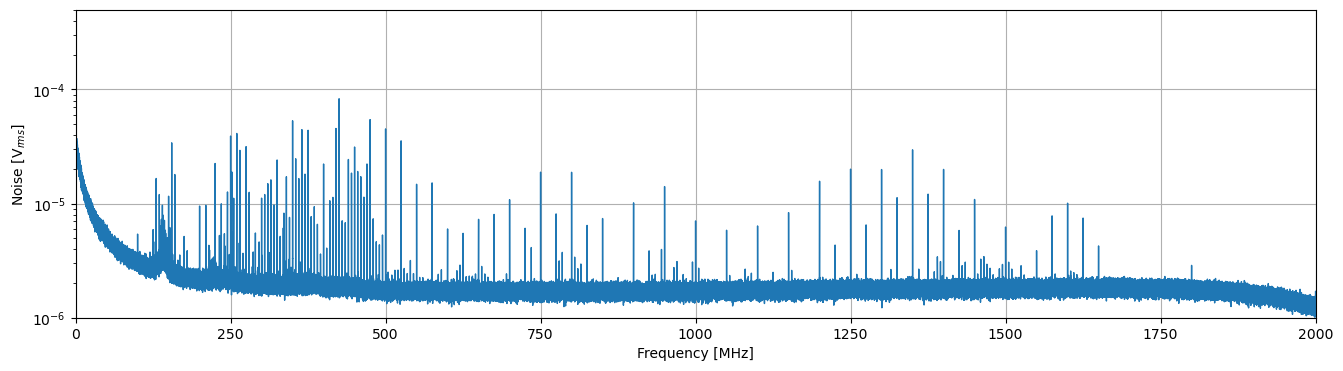

In [289]:

frequency_range = [0,2000]

bin_width = fft_freq[1]-fft_freq[0]

figure(figsize=(16,4))
plot(fft_freq/1e6, psd_final*np.sqrt(bin_width),linewidth=1)
a0=gca()
a0.set_xlabel("Frequency [MHz]")
a0.set_ylabel("Noise [V$_{rms}$]")
# a0.set_ylabel("Noise density [V/$\sqrt{Hz}$]")
a0.set_xlim(*frequency_range)
a0.set_ylim(1e-6,0.5e-3)
yscale("log")
grid()


data_save = {"f[Hz]":fft_freq,
             "psd[V/rtHz]":psd_final}
joblib.dump(data_save, "data_dcrc/PSD_1029c.joblib")



In [292]:

psd_save=data_save
noise_voltage = psd_save["psd[V/rtHz]"]*np.sqrt(bin_width)
freq  = psd_save["f[Hz]"]/1e6
threshold = 4e-6
noise_sum = np.linalg.norm(noise_voltage[(freq>180)&(freq<2000)&(noise_voltage>threshold)])
print(noise_sum)

0.00023842989738639478


# Interactively, waterfall

In [70]:
trigger_channel = 1
trigger_mode    = "AUTO"

acquire_channel = 1
n_avg = 2
fft_trace_length = 65536
acquire_length = fft_trace_length*n_avg



waterfall_buffer_frames = 200
waterfall_to_spectrum_ratio = 2
spectrum_buffer_frames = waterfall_buffer_frames
spectrum_vertical_bins = 100
spectrum_vertical_range_dbV = [-180,0]


# Set Scope Run Mode
scope.write(f"ACQuire:BANDwidth MAX")
scope.write(f":ACQuire:TYPE {trigger_mode}")
scope.write(f":ACQuire:POINts:ANALog {acquire_length}")
# Get the Scope calibration data 
calibration_data = vs.get_calibration(scope, read_channel = [acquire_channel])


#
# Initialize two arrays
# One for spectrum
# One for waterfall
img_spectrum  = np.zeros((spectrum_vertical_bins, fft_trace_length//2))
img_waterfall = np.zeros((waterfall_buffer_frames, fft_trace_length//2))

def update_waterfall(img_waterfall, newline):
    img_waterfall[0] = newline

def update_spectrum(img_spectrum, img_waterfall, spectrum_buffer_frames):
    for i_col in np.arange(img_waterfall.shape[1]):
        img_spectrum[:,i_col] = np.histogram(img_waterfall[:spectrum_buffer_frames,i_col], bins = spectrum_vertical_bins, range=spectrum_vertical_range_dbV)[0]

    
t_start = time.time()
# while(True):
# if 1:
for j in range(waterfall_buffer_frames):
    t1 = time.time()
    data, time_series=vs.read_waveform(scope, trigger_channel = trigger_channel, read_channel = [acquire_channel], acquire_length = acquire_length, calibrate = True, initialize = False, calibration_data=calibration_data)
    t_stop = time.time()
    
    sampling_frequency = 1/(time_series[1]-time_series[0])
    fft_freq, pxx  = scipy.signal.periodogram(data[acquire_channel].reshape(n_avg, fft_trace_length), fs=sampling_frequency, axis=1)
    psd = np.log10(np.sqrt(np.mean(pxx, axis=0)))[1:]*20
    fft_freq = fft_freq[1:]


    # Add new line to waterfall
    img_waterfall[j] = psd

    # update spectrum and plot,
    # BUT only every 0.1 seconds
    t2 = time.time()

    if j%30==0:
        print(j, t2-t1)



update_spectrum(img_spectrum, img_waterfall,spectrum_buffer_frames)


0 0.15389084815979004
30 0.0926210880279541
60 0.09061694145202637
90 0.09353208541870117
120 0.08875536918640137
150 0.092559814453125
180 0.07912397384643555


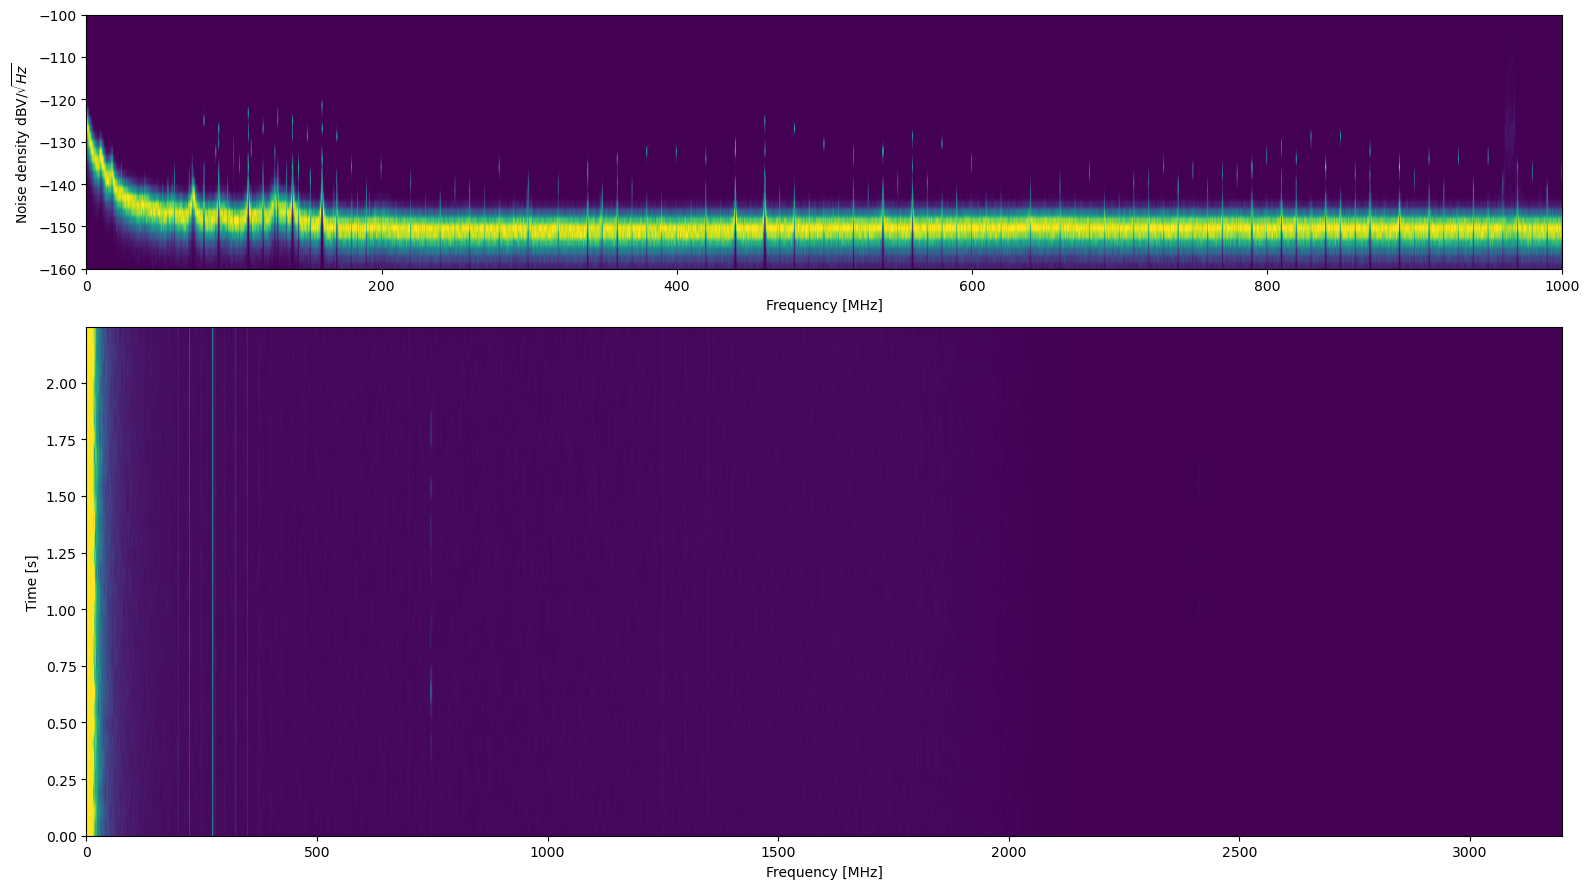

In [128]:
frequency_range = [0,1000]
voltage_range = [-160,-100]

fig, (a0, a1) = plt.subplots(2, 1, figsize=(16,9), gridspec_kw={'height_ratios': [1, waterfall_to_spectrum_ratio]})  

a0.imshow(img_spectrum,origin="lower", aspect='auto', cmap="viridis", \
          extent=[0,fft_freq[-1]/1e6,spectrum_vertical_range_dbV[0],spectrum_vertical_range_dbV[1]],
          vmax = np.percentile(img_spectrum.flatten(), 99.5))
a0.set_xlabel("Frequency [MHz]")
a0.set_ylabel("Noise density dBV/$\sqrt{Hz}$")
a0.set_xlim(*frequency_range)
a0.set_ylim(*voltage_range)

a1.imshow(img_waterfall,origin="upper", aspect='auto', cmap="viridis", extent=[0,fft_freq[-1]/1e6,0, t_stop-t_start],
          vmax = np.percentile(img_waterfall.flatten(), 99.5))
a1.set_ylabel("Time [s]")
a1.set_xlabel("Frequency [MHz]")
# a1.set_xlim(*frequency_range)

# a0.set_xticklabels([])
# plt.subplots_adjust(wspace=0, hspace=0)
tight_layout()
# show()

# Dev

In [2]:
cv2.namedWindow('img', cv2.WINDOW_NORMAL)

for i in range(100):
    A = np.random.randn(10,10)
    cv2.imshow("img", A)
    cv2.waitKey(1)  # it's needed, but no problem, it won't pause/wait

In [11]:
# img = np.random.uniform(0,100,1920*1080)
# img = img.reshape(1080,1920)
# figure(figsize=(16, 9), dpi=80)

# # h=imshow(img, interpolation =None)

# t1 = time.time()

# for i in range(1):
#     img = np.random.uniform(0,100,(1080,1920))
#     h.set_data(img)
#     draw(),pause(0.1)
# t2 = time.time()
# print(t2-t1)

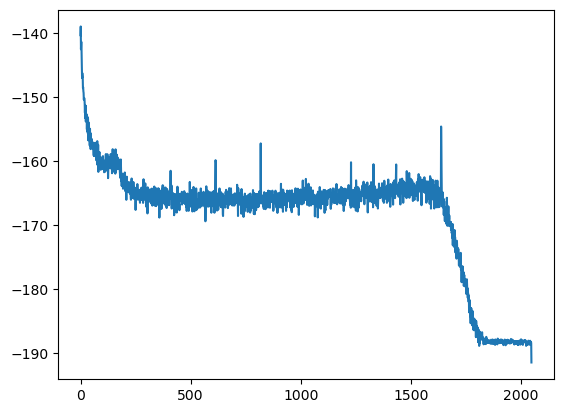

In [118]:
plot(img_waterfall[0])

In [5]:
import cv2
import numpy as np

  KeyboardInterrupt. You pressed ctrl c...


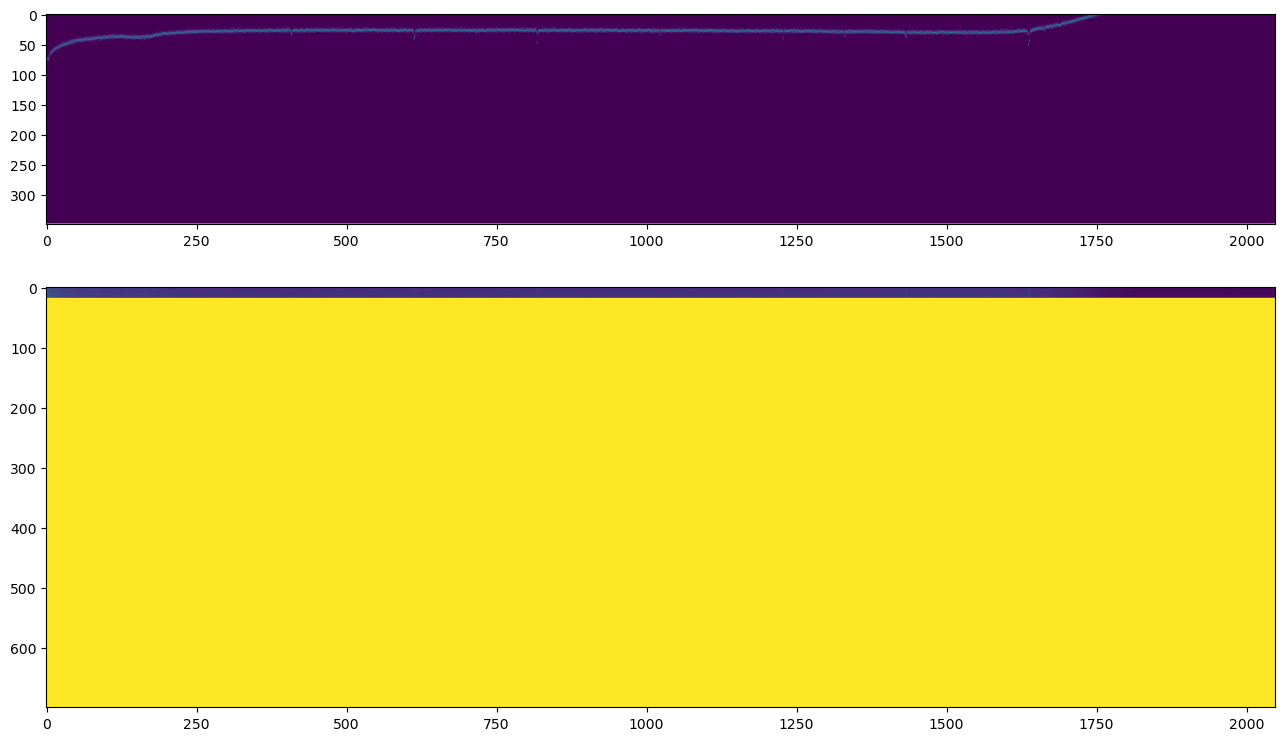

In [119]:
trigger_channel = 1
trigger_mode    = "AUTO"

acquire_channel = 1
n_avg = 20
fft_trace_length = 4096
acquire_length = fft_trace_length*n_avg



waterfall_buffer_frames = 700
waterfall_to_spectrum_ratio = 2
spectrum_buffer_frames = 30
spectrum_vertical_bins = int(waterfall_buffer_frames/waterfall_to_spectrum_ratio)
spectrum_vertical_range_dbV = [-180,0]


# Set Scope Run Mode
scope.write(f"ACQuire:BANDwidth MAX")
scope.write(f":ACQuire:TYPE {trigger_mode}")
scope.write(f":ACQuire:POINts:ANALog {acquire_length}")
# Get the Scope calibration data 
calibration_data = vs.get_calibration(scope)


# Initialize two arrays
# One for spectrum
# One for waterfall
img_spectrum  = np.zeros((spectrum_vertical_bins, fft_trace_length//2))
img_waterfall = np.zeros((waterfall_buffer_frames, fft_trace_length//2))

def update_waterfall(img_waterfall, newline):
    for i_row in range(1,img_waterfall.shape[0]):
        img_waterfall[i_row] = img_waterfall[i_row-1] 
    img_waterfall[0] = newline
    return img_waterfall

def update_spectrum(img_spectrum, img_waterfall, spectrum_buffer_frames):
    for i_col in np.arange(img_waterfall.shape[1]):
        img_spectrum[:,i_col] = np.histogram(img_waterfall[:spectrum_buffer_frames,i_col], bins = spectrum_vertical_bins, range=spectrum_vertical_range_dbV)[0]

    
fig, (a0, a1) = plt.subplots(2, 1, figsize=(16,9), gridspec_kw={'height_ratios': [1, waterfall_to_spectrum_ratio]})  
# f, (a0, a1) = plt.subplots(2, 1, figsize=(16,9), height_ratios=[1, waterfall_to_spectrum_ratio])  
    
# while(True):
# if 1:
t1 = time.time()
for j in range(100):
    try:
        data, time_series=vs.read_waveform(scope, trigger_channel = trigger_channel, read_channel = [acquire_channel], acquire_length = acquire_length, calibrate = True, initialize = False, calibration_data=calibration_data)
        
        sampling_frequency = 1/(time_series[1]-time_series[0])
        fft_freq, pxx  = scipy.signal.periodogram(data[acquire_channel].reshape(n_avg, fft_trace_length), fs=sampling_frequency, axis=1)
        psd = np.log10(np.sqrt(np.mean(pxx, axis=0)))[1:]*20
        fft_freq = fft_freq[1:]


        # Add new line to waterfall
        img_waterfall = update_waterfall(img_waterfall, psd)


        # update spectrum and plot,
        # BUT only every 0.1 seconds
        t2 = time.time()

        # print(t2-t1)

        if (t2-t1)>0.3:
            # clear_output(wait=True)
    
            t1=t2
            update_spectrum(img_spectrum, img_waterfall,spectrum_buffer_frames)
            a0.imshow(img_spectrum,origin="lower")
            a1.imshow(img_waterfall)
            plt.draw()
            
        else:
            continue


    except KeyboardInterrupt:
        print("  KeyboardInterrupt. You pressed ctrl c...")
        break                
    except Exception as e: # Any other exception
        print("  Exception:", str(e)) # Displays the exception without raising it
        continue            